# Data Requirement and Bayes Classifier

## 1. Data download and preprocessing

In [2]:
import requests
import zipfile

def download_dataset(url, filename):
    data = requests.get(url)
    with open(filename, 'wb') as code:
        code.write(data.content)
    print(f"Downloading the datasets {filename} complete.")
    data_file = zipfile.ZipFile(filename, 'r')
    data_list = data_file.namelist()

    for file in data_list:
        data_file.extract(file, 'd:/Desktop/AI-ML-methods/homework/assignment4/')
    data_file.close()
    print(f"Unzipping the datasets {filename} complete.")

url = 'http://www.nustm.cn/member/rxia/ml/data/gmm.zip'
download_dataset(url, 'gmm.zip')

ConnectionError: HTTPConnectionPool(host='www.nustm.cn', port=80): Max retries exceeded with url: /member/rxia/ml/data/gmm.zip (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x000001D1AA75ADE0>: Failed to resolve 'www.nustm.cn' ([Errno 11001] getaddrinfo failed)"))

In [2]:
import os
import numpy as np

def load_data(root_dir):
    X = []
    y = []
    categories = os.listdir(root_dir)
    for i, file in enumerate(categories):
        file_path = os.path.join(root_dir, file)
        text = np.loadtxt(file_path, skiprows=1)
        X.append(text[:, 1:])
        y.append(text[:, 0])
    return np.concatenate(X, axis=0), np.concatenate(y, axis=0)

root_dir = 'd:/Desktop/AI-ML-methods/homework/assignment4/gmm'

def load_file_data(file_path):
    X = []
    y = []
    text = np.loadtxt(file_path, skiprows=1)
    X.append(text[:, 1:])
    y.append(text[:, 0])
    return np.concatenate(X, axis=0), np.concatenate(y, axis=0)

file_path = 'd:/Desktop/AI-ML-methods/homework/assignment4/gmm/GMM6.txt'
X, y = load_file_data(file_path)

(1000, 2) (1000,)


C:\Users\13476\AppData\Local\Temp\ipykernel_7336\267002125.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  marker='o', s=5, cmap=plt.cm.get_cmap('Set1', n_classes))


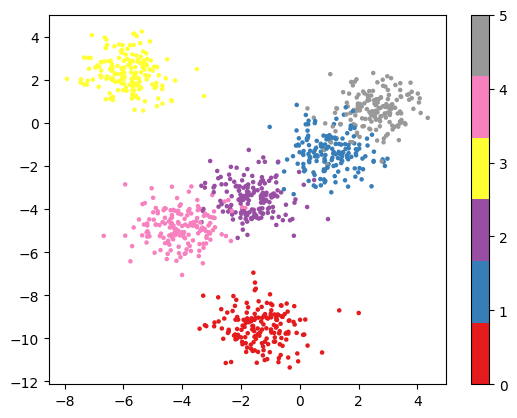

In [3]:
print(X.shape, y.shape)
import matplotlib.pyplot as plt
n_classes = int(np.max(np.unique(y))) + 1
plt.scatter(X[:, 0], X[:, 1], c=y, \
            marker='o', s=5, cmap=plt.cm.get_cmap('Set1', n_classes))
plt.colorbar()
plt.show()

## Gaussian Naive Bayes Classifier

Returns
-------
log_posterior : :py:class:`ndarray <numpy.ndarray>` of shape `(N, K)`
    Unnormalized log posterior probability of each class for each
    example in $X$

Notes
-----
Unnormalized log posterior for example :math:$\mathbf{x}_i$ 
and class: math:$c$ is::

$$
\begin{align*}
\log P(y_i = c \mid \mathbf{x}_i, \theta)
    &\propto \log P(y=c \mid \theta) +
        \log P(\mathbf{x}_i \mid y_i = c, \theta) \\
    &\propto \log P(y=c \mid \theta)
        \sum\limits_{j=1}^M \log P(x_j \mid y_i = c, \theta)
\end{align*}
$$

In the Gaussian naive Bayes model, the feature likelihood for class
:math:$c$, :math:$P(\mathbf{x}_i \mid y_i = c, \theta)$ is assumed to
be normally distributed

$$\mathbf{x}_i \mid y_i = c, \theta \sim \mathcal{N}(\mu_c, \Sigma_c)$$

In [18]:
import numpy as np

class GaussianNBC(object):
    def __init__(self, eps=1e-6):
        self.classes = None # (n_classes,)
        self.n_classes = None # num of classes
        self.parameters = {
            "mean": None,  # shape: (K, M)
            "sigma": None,  # shape: (K, M)
            "prior": None,  # shape: (K,)
        }
        self.hyperparameters = {"eps": eps}

    def fit(self, X, y):
        """
        Fit the model parameters via maximum likelihood.
        Parameters
        ----------
        X : :py:class:`ndarray <numpy.ndarray>` of shape `(N, M)`
            A dataset consisting of `N` examples, each of dimension `M`
        y: :py:class:`ndarray <numpy.ndarray>` of shape `(N,)`
            The class label for each of the `N` examples in `X`  
        """
        self.classes = np.unique(y) # get unique classes
        self.n_classes = len(self.classes) # num of classes
        K = self.n_classes
        N, M = X.shape

        P = self.parameters
        H = self.hyperparameters
        P["mean"] = np.zeros((K, M))
        P["sigma"] = np.zeros((K, M))
        P["prior"] = np.zeros((K,))

        for i, cls_ in enumerate(self.classes):
            cls_indices = np.where(y == cls_)[0] # get indices of class cls_
            X_cls = X[cls_indices]

            P["mean"][i, :] = np.mean(X_cls, axis=0)
            P["sigma"][i, :] = np.var(X_cls, axis=0) + H["eps"]
            P["prior"][i] = len(cls_indices) / N
        return self
    
    def predict(self, X):
        """
        predict the class label for each example in **X** via trained Gaussion NBC.
        """
        return self.classes[np.argmax(self._log_posterior(X), axis=1)]

    def _log_posterior(self, X):
        
        K = self.n_classes
        P = self.parameters
        log_posterior = np.zeros((X.shape[0], K))
        for i in range(K):
            mu = P["mean"][i]
            sigsq = P["sigma"][i]
            prior = P["prior"][i]

            # log likelihood = log X | N(mu, sigsq)
            log_likelihood = -0.5 * np.sum(np.log(2 * np.pi * sigsq))
            log_likelihood -= 0.5 * np.sum(((X - mu) ** 2) / sigsq, axis=1)
            log_posterior[:, i] = log_likelihood + np.log(prior)
        return log_posterior

In [19]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

# 初始化交叉验证分割器和分类器模型
kf = KFold(n_splits=5, shuffle=True, random_state=42)
classifier = GaussianNBC()

# 用于存储每个交叉验证模型的评分
cv_scores = []

# 执行 N 倍交叉验证
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    score = np.mean(y_pred == y_test)
    cv_scores.append(score)

# 输出每个交叉验证模型的评分
for i, score in enumerate(cv_scores):
    print("Fold {}: {}".format(i+1, score))

# 输出交叉验证评分的平均值
print("Average CV Score:", np.mean(cv_scores))

Fold 1: 0.945
Fold 2: 0.945
Fold 3: 0.965
Fold 4: 0.96
Fold 5: 0.97
Average CV Score: 0.9570000000000001


C:\Users\13476\AppData\Local\Temp\ipykernel_27016\3931304558.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.scatter(X[:, 0], X[:, 1], c=y, marker='x',cmap=plt.cm.get_cmap('Set1', n_classes))
C:\Users\13476\AppData\Local\Temp\ipykernel_27016\3931304558.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.contourf(xx, yy, flat_y, alpha=0.3, cmap=plt.cm.get_cmap('gray', n_classes))


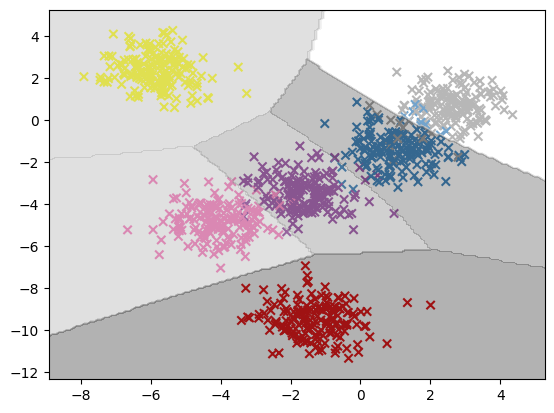

In [28]:
import matplotlib.pyplot as plt

def visualization(classifier, X, y):
    plt.figure()
    # X.shape: (N, D), W.shape: (D, C), y.shape: (N, 1)
    n_classes = int(np.max(np.unique(y))) + 1
    plt.scatter(X[:, 0], X[:, 1], c=y, marker='x',cmap=plt.cm.get_cmap('Set1', n_classes))

    # Generate a grid of points for visualization
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))
    flat_X = np.concatenate([xx.ravel().reshape(-1, 1), yy.ravel().reshape(-1, 1)], axis=1)
    # print(inp.shape)  # (num of pixels, 2)
    flat_y = classifier.predict(flat_X)
    flat_y = flat_y.reshape(xx.shape)
    # Plot decision boundary
    plt.contourf(xx, yy, flat_y, alpha=0.3, cmap=plt.cm.get_cmap('gray', n_classes))
    plt.show()

visualization(classifier, X, y)
